# Guide to Extracting Data w/ APIs from the Dreem Headband

<!--<img src="https://i.imgur.com/RI0yuaz.png" width="500"/>-->
<img src="https://imgur.com/hTJol4M.png" width="500"/>

Why dream when you can dreem? Introducing the [Dreem 2](https://dreem.com/), a headband that is capable of providing not only raw, high frequency EEG measurements, but also sleep stage predictions throughout the night. In this notebook, we'll be *extracting* data from a Dreem headband, *visualizing* its raw EEG signals and its sleep stage predictions, and then *analyzing* this data.

Note that this notebook assumes that you are conducting a clinical trial, and have registered this through Dreem.

If you want to know more about the Dreem 2 headband, see the [README](https://github.com/alrojo/wearipedia/tree/main/wearables/dream-2-headband) for a detailed analysis of performances, sensors, data privacy, and extraction pipelines.

TODO: FIX GITHUB README LINK

While Dreem does not support an official API, as stated on the site (["do not have a public or private API for the moment"](https://dreem.com/clinicaltrials)), we reverse-engineer the API implicitly used when visiting https://dreem-viewer.rythm.co/ and viewing clinical trial health records, allowing you to programmatically extract all of your clinical trial data at once (instead of having to click through a web interface).

Overall, the Dreem API makes the following values available:

Parameter Name  | Sampling Frequency 
-------------------|------------------
Sleep stage classification (S0/1/2/3, MT, REM) | every 30 seconds
7 separate raw EEG signals |  250Hz
7 separate filtered EEG signals |  250Hz
Raw accelerometer (x, y, z, norm) | 50Hz
Filtered accelerometer (x, y, z) | 50Hz
Positiongram | 10Hz

Note that when we say "filtered" the EEG signal is filtered via a Butterworth bandpass filter of order 2 (0.4-35Hz) and the accelerometer signal is filtered via a Butterworth bandpass filter of order 2 (0.1-0.5Hz), see [this official article](https://support.dreem.com/hc/en-us/articles/360021664499-How-to-read-H5-file) and [this scientific article](https://academic.oup.com/sleep/article/43/11/zsaa097/5841249) for more.

<br><br>
In this guide, we sequentially cover the following **five** topics to extract from the unofficial Dreem API:
1. **Set up**
    - We include some details about what you'd be expected to do before running this notebook.
2. **Authentication/Authorization**
    - This is seamless, only requiring the clinical trial admin username and password.
3. **Data extraction**
    - Extraction is simple, requiring only clinical trial admin email and password. We provide some code to interface with the backend API.
4. **Data visualization**
    - 4.1: We visualize the hypnogram for the given sleep session.
    - 4.2: We also visualize an EEG signal within a time interval of your choice.
    - 4.3: We also visualize the variance of an EEG signal within a short time interval (1 second) over different sleep stages.
5. **Data analysis**
    - 5.1: We check whether the change in the variance of a representative EEG signal within a short time interval (1 second) is statistically significant between a wake stage vs. a sleep stage.
    - 5.2: We check whether the change in the norm of the acceleration within a short time interval (1 second) is statistically significant between a wake stage vs. a sleep stage.

# 1. Set Up

TODO: explain this. We aren't really sure because we didn't have to do this part. Maybe we can reach out to Dalia soon to get an overview?

# 2. Authentication/Authorization

Due to confidentiality requirements, we cannot share our own login credentials (though you can use your own, of course).

Note that the website you would normally log into is https://dreem-viewer.rythm.co, so to get a more user-friendly table of records you can inspect in your browser, visit that link.

In [ ]:
#@title Enter login credentials
email = "" #@param {type:"string"}
password = "" #@param {type:"string"}

import base64
import json
import requests

authorization_str = 'Basic ' + base64.b64encode(bytes(email + ':' + password, 'utf-8')).decode()

auth_dict = json.loads(requests.post('https://login.rythm.co/token/', headers={'Authorization': authorization_str}).text)

# 3. Data Extraction

Now we extract data from the API.

First, we get all available users. This gives us a mapping between usernames and user id's.

In [ ]:
#@title Get available users

import pprint

def get_aux_records(auth_dict):
    url = 'https://api.rythm.co/v1/dreem/algorythm/restricted_list/9f38863b-8180-4dd4-81cf-9395800ae0cc/record/?limit=100&offset=0'

    headers = {'Authorization': 'Bearer ' + auth_dict['token']}

    out = requests.get(url, headers=headers)

    out_dict = json.loads(out.text)

    return out_dict

def get_user2id_mapping(auth_dict, user_ids):
    url = 'https://api.rythm.co/v1/dreem/dreemer/dreemer/details/'
    headers = {'Authorization': 'Bearer ' + auth_dict['token'],
            'Content-Type': 'application/json'}

    payload = {
        'id': [user_id for user_id in user_ids]
    }

    out = requests.post(url, headers=headers, data='{"id":["ce73192e-874c-4576-a2e3-27b0dc0ebcee","1222a474-bc02-44ab-b4c5-d66dc34620b7","e1ec95b0-b71b-4499-b73c-cf9b1e3576c2"]}').text

    return {x['pseudo']: x['dreemer'] for x in json.loads(out)}

# we care about aux_records because:
# (1) it contains the user_ids
# (2) it contains a mapping between references and record id's
aux_records = get_aux_records(auth_dict)

# (1) here
user_ids = set([result['user'] for result in aux_records['results']])

map = get_user2id_mapping(auth_dict, user_ids)

print('Available users:')
pprint.pprint(map)

Available users:
{'61843_test01@dreem.com': 'e1ec95b0-b71b-4499-b73c-cf9b1e3576c2',
 '61843_test02@dreem.com': '1222a474-bc02-44ab-b4c5-d66dc34620b7',
 '61843_test03@dreem.com': 'ce73192e-874c-4576-a2e3-27b0dc0ebcee'}


Next, we filter to only download and display records from a particular user. At the end, we have a Pandas dataframe called `records_df` that contains the raw data behind the table you normally see through the admin portal.

<img src="https://i.imgur.com/0P810M1.png" width=1000></img>

In [ ]:
#@title Filter to display only records from a specific user
username = "61843_test03@dreem.com" #@param {type:"string"}

uname_filter = username

uid = [uid for uname, uid in map.items() if uname == uname_filter][0]

# filter to only include this username
filtered_aux_records = [record for record in aux_records['results'] if record['user'] == uid]

record_ids = [record['id'] for record in filtered_aux_records]

import pandas as pd

def get_table_records():
    # this is distinct from aux_records

    # we get the *actual* info that is displayed on the table
    # in the web portal
    url = 'https://api.rythm.co/v1/dreem/record/report/details/'

    headers = {
        'Authorization': 'Bearer ' + auth_dict['token'],
        'Content-Type': 'application/json'
    }

    payload = {
        'id': record_ids
    }

    out_dict = json.loads(requests.post(url, headers=headers, data=json.dumps(payload)).text)

    return out_dict

def records_to_df(table_records, aux_records):
    columns = {
        'record_id': 'Record ID',
        'record_start_iso': 'Start (ISO)',
        'record_stop_iso': 'Stop (ISO)',
        'timezone': 'Timezone',
        'record_duration': 'Duration (seconds)',
        'proportion_good_quality_eeg1': 'Channel quality 1',
        'proportion_good_quality_eeg2': 'Channel quality 2',
        'proportion_good_quality_eeg4': 'Channel quality 4',
        'proportion_off_head': 'Proportion off head',
        'proportion_scorable': 'Proportion scorable'
    }

    list_of_dicts = []

    for record in table_records:


        d = {columns[key]: endpoint for key, endpoint in record['endpoints'].items() if key in columns.keys()}

        d['Record ID'] = record['record']

        list_of_dicts.append(d)

    records_df = pd.DataFrame(list_of_dicts, columns=columns.values())

    # (2) here
    id2ref_map = {aux_record['id']: aux_record['reference'] for aux_record in aux_records}

    records_df.insert(0, 'Ref', records_df['Record ID'].apply(lambda id: id2ref_map[id]))

    return records_df

table_records = get_table_records()

#filtered_table_records = [record for record in table_records if record['user'] == uid]

records_df = records_to_df(table_records, filtered_aux_records)

records_df = records_df.sort_values('Ref', ascending=False,
                                    ignore_index=True)

records_df

,Ref,Record ID,Start (ISO),Stop (ISO),Timezone,Duration (seconds),Channel quality 1,Channel quality 2,Channel quality 4,Proportion off head,Proportion scorable
0,2751857,6c2faef3-e9a6-46a0-b34d-9afdb8b24ec8,2022-06-14T19:20:27-05:00,2022-06-14T20:23:12-05:00,America/Chicago,3765.0,0.226766,0.008497,0.353160,1.000000,0.296000
1,2751856,5096a84f-b971-446e-9d49-0202fdf7c9a8,2022-06-14T19:14:25-05:00,2022-06-14T19:18:14-05:00,America/Chicago,229.0,0.009009,0.000000,0.000000,1.000000,0.000000
2,2751854,44fa039b-8b16-4a2f-b8ef-d7e5a69157b8,2022-06-15T00:55:16-05:00,2022-06-15T02:44:37-05:00,America/Chicago,6561.0,0.050213,0.138466,0.426354,0.561644,0.853881
3,2751380,d3c1b33e-c591-48a9-95bc-38282e69840e,2022-06-14T17:19:32-05:00,2022-06-14T17:19:55-05:00,America/Chicago,23.0,0.000000,0.090909,0.090909,NaN,NaN
4,2751349,423eafa3-2a71-40b3-ac39-b6dcb6f3d43a,2022-06-14T03:38:12-05:00,2022-06-14T14:58:41-05:00,America/Chicago,40829.0,0.710756,0.783470,0.734684,0.023495,0.969897
5,2751348,5039f0c2-239e-41e8-9caa-abcfe071615c,2022-05-24T04:15:58-07:00,2022-05-24T10:49:51-07:00,America/Los_Angeles,23633.0,0.557961,0.656210,0.614526,0.052030,0.779188
6,2751347,2ca402e4-c2fb-4c72-866d-c73e49d5ce65,2022-05-27T05:13:46-07:00,2022-05-27T06:16:06-07:00,America/Los_Angeles,3740.0,0.305556,0.419872,0.565705,1.000000,0.604839


Now, we wish to extract a particular record from this table. Since we see that record 2751349 is the most complete (11 hours with [good enough data to be scored by a human 97% of the time](https://support.dreem.com/hc/en-us/articles/360021372739-How-to-read-the-Record-Quality-metric), we download all of its associated data (464MB of raw accelerometer + EEG data, and its hypnogram). The raw data is stored as a file `2751349.h5` on disk and the hypnogram is parsed and stored in a Pandas dataframe `hypnogram_df`.

Since the raw data is stored in HDF5 format, we get all of the cool advantages of HDF5: an elegant hierarchical format with fast array-like indexing that loads into memory only when absolutely necessary.

In [ ]:
#@title Record ref number
record_ref = 2751349 #@param {type:"integer"}

from tqdm import tqdm

def get_download_info(record_id, record_ref):
    # get the record id
    id = records_df[records_df['Ref'] == record_ref]['Record ID'].iloc[0]

    url = f'https://api.rythm.co/v1/dreem/algorythm/record/{id}/h5/?filename={record_ref}'

    headers = {
        'Authorization': 'Bearer ' + auth_dict['token']
    }

    out_dict = json.loads(requests.get(url, headers=headers).text)

    return out_dict

def get_hypnogram(record_id):

    url = f'https://api.rythm.co/v1/dreem/record/record/{record_id}/latest_hypnogram_as_txt/'

    headers = {
        'Authorization': 'Bearer ' + auth_dict['token']
    }

    hypnogram_text = requests.get(url, headers=headers).text

    from io import StringIO

    # get index of header
    idx_start = [i for i,l in enumerate(hypnogram_text.split('\n')) if 'Sleep Stage' in l][0]

    hypnogram = pd.read_csv(StringIO('\n'.join(hypnogram_text.split('\n')[idx_start:])), sep='\t')

    return hypnogram

record_id = records_df[records_df['Ref'] == record_ref]['Record ID'].iloc[0]

print('Getting download URL...')
download_info = get_download_info(record_id, record_ref)

assert download_info['status_display'] == 'Available'

download_url = download_info['data_url']

def download_file(dowload_url, download_path):

    # Streaming, so we can iterate over the response.
    response = requests.get(download_url, stream=True)
    total_size_in_bytes= int(response.headers.get('content-length', 0))
    block_size = 1024 #1 Kibibyte
    progress_bar = tqdm(total=total_size_in_bytes, unit='iB', unit_scale=True)
    with open(download_path, 'wb') as file:
        for data in response.iter_content(block_size):
            progress_bar.update(len(data))
            file.write(data)

    progress_bar.close()

    if total_size_in_bytes != 0 and progress_bar.n != total_size_in_bytes:
        print("ERROR, something went wrong")

print('Now downloading text hypnogram...')

hypnogram_df = get_hypnogram(record_id)

print('Now downloading raw EEG/accelerometer data...\n')

download_file(download_url, str(record_ref) + '.h5')

Getting download URL...
Now downloading text hypnogram...
Now downloading raw EEG/accelerometer data...



100%|██████████| 464M/464M [00:19<00:00, 23.8MiB/s]


# 4. Data Visualization

Now that we've downloaded all of the data, let's visualize some of it.

## 4.1. Hypnogram Plot

First, let's plot the hypnogram for this sleep session. This plot is very useful as it is a [standard plot](https://en.wikipedia.org/wiki/Hypnogram) to visualize the stages of sleep over time.

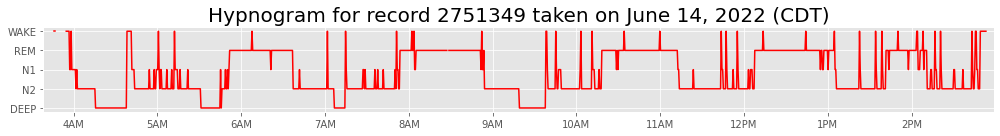

In [ ]:
#@title Plot hypnogram

from datetime import datetime, timezone
import numpy as np
import h5py
import matplotlib.pyplot as plt
import pytz

# get user's timezone
timezone_user = records_df[records_df['Ref'] == record_ref]['Timezone'].iloc[0]

def utc_to_local(utc_dt):
    return utc_dt.replace(tzinfo=timezone.utc).astimezone(tz=pytz.timezone(timezone_user))

# we do this stage_to_int thing to ensure that the
# stages appear in order on the y-axis
stage_to_int = [
    'SLEEP-MT',
    'SLEEP-S3',
    'SLEEP-S2',
    'SLEEP-S1',
    'SLEEP-REM',
    'SLEEP-S0'
]

stages_to_real_names = {
    'SLEEP-MT': None,
    'SLEEP-S3': 'DEEP',
    'SLEEP-S2': 'N2',
    'SLEEP-S1': 'N1',
    'SLEEP-REM': 'REM',
    'SLEEP-S0': 'WAKE'
}

stage_ints = np.array(hypnogram_df['Sleep Stage'].apply(lambda x: stage_to_int.index(x)))

num_stages = len(stage_to_int)

# load in hdf5 file
f = h5py.File('2751349.h5', 'r')

# turn into seconds so we can plot
hypnogram_df['seconds'] = hypnogram_df['Time [hh:mm:ss]'].apply(lambda x: 3600 * int(x.split(':')[0]) + 60 * int(x.split(':')[1]) + int(x.split(':')[-1]))

# get the date this was taken
date = datetime.fromtimestamp(f.attrs['start_time'])

timezone_str = utc_to_local(date).strftime('%Z')
date = utc_to_local(date).strftime('%B %d, %Y')

# get the contiguous regions in stage_ints to plot
# these separately
empty_idxes = np.where(stage_ints != 0)[0]

regions = []

cur_region_start = -1

cur_region_end = -1

for i, (idx1, idx2) in enumerate(zip(empty_idxes[:-1], empty_idxes[1:])):
    if cur_region_start == -1:
        cur_region_start = idx1
        cur_region_end = idx2

    # either diff > 1 or we're at the end
    if idx2 - idx1 > 1 or i == empty_idxes[:-1].shape[0] - 1:
        cur_region_end = idx1
        # add 1 to account for extra dummy entry in heart_rate_day
        # at the beginning
        regions.append((cur_region_start+1, cur_region_end+1))

        cur_region_start = -1
        cur_region_end = -1

with plt.style.context('ggplot'):
    plt.figure(figsize=(14, 2))

    plt.title(f'Hypnogram for record {record_ref} taken on {date} ({timezone_str})',
              fontsize=20)
    
    for region_start, region_end in regions:
        plt.plot(hypnogram_df['seconds'].iloc[region_start:region_end] / 3600,
                stage_ints[region_start:region_end], color='red')

    plt.yticks(ticks=list(range(1, num_stages)),
            labels=[stages_to_real_names[stage] for stage in stage_to_int[1:]])
    
    plt.xticks(ticks=[4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14],
               labels=['4AM', '5AM', '6AM', '7AM', '8AM', '9AM', '10AM', '11AM', '12PM', '1PM', '2PM'])

    # just set the xlim so that it extends all the way left
    # and right
    plt.xlim(*(hypnogram_df['seconds'] / 3600).iloc[[0, -1]])

    plt.tight_layout()

    plt.show()

## 4.2. Hypnogram + EEG plot

Now let's plot some EEG signals (filtered). This will allow us to obtain a very granular view at the EEG signal throughout the entire sleep session. In particular, we will reproduce the below plot that you can see yourself on the admin portal. Feel free to tweak the inputs to the plot and see how it reacts!

<img src="https://imgur.com/YCMQoPP.png" width=1000></img>

*Above is a plot taken directly from the online admin web interface!*

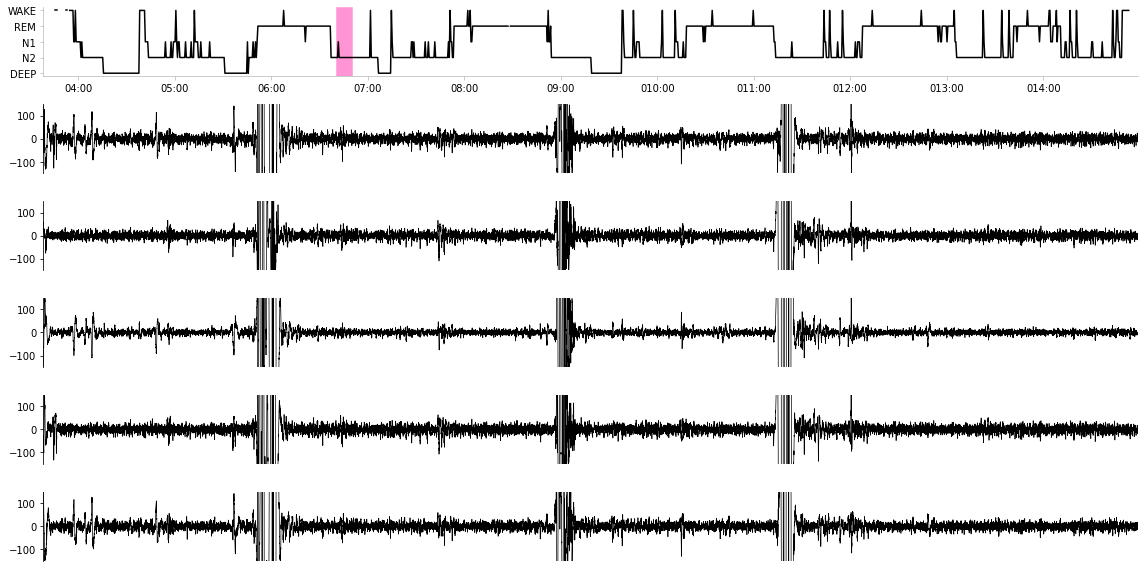

In [ ]:
#@title Plot EEG signals
date = "2022-06-14" #@param {type:"date"}
start_hour =  6 #@param {type:"integer"}
start_minute =   40#@param {type:"integer"}
end_hour =  6 #@param {type:"integer"}
end_minute =   50#@param {type:"integer"}
channel_1 = 1 #@param {type:"integer"}
channel_2 = 2 #@param {type:"integer"}
channel_3 = 4 #@param {type:"integer"}
channel_4 = 5 #@param {type:"integer"}
channel_5 = 6 #@param {type:"integer"}

eeg_channel_nums = [channel_1, channel_2, channel_3,
                    channel_4, channel_5]

#eeg_channel_nums = [1, 2, 4, 5, 6]

date_provided = date

fig, ax = plt.subplots(6, 1, figsize=(16, 8))

# get user's timezone
timezone_user = records_df[records_df['Ref'] == record_ref]['Timezone'].iloc[0]

def utc_to_local(utc_dt):
    return utc_dt.replace(tzinfo=timezone.utc).astimezone(tz=pytz.timezone(timezone_user))

# we do this stage_to_int thing to ensure that the
# stages appear in order on the y-axis
stage_to_int = [
    'SLEEP-MT',
    'SLEEP-S3',
    'SLEEP-S2',
    'SLEEP-S1',
    'SLEEP-REM',
    'SLEEP-S0'
]

stages_to_real_names = {
    'SLEEP-MT': None,
    'SLEEP-S3': 'DEEP',
    'SLEEP-S2': 'N2',
    'SLEEP-S1': 'N1',
    'SLEEP-REM': 'REM',
    'SLEEP-S0': 'WAKE'
}

stage_ints = np.array(hypnogram_df['Sleep Stage'].apply(lambda x: stage_to_int.index(x)))

num_stages = len(stage_to_int)

# load in hdf5 file
f = h5py.File('2751349.h5', 'r')

# turn into seconds so we can plot
hypnogram_df['seconds'] = hypnogram_df['Time [hh:mm:ss]'].apply(lambda x: 3600 * int(x.split(':')[0]) + 60 * int(x.split(':')[1]) + int(x.split(':')[-1]))

# get the date this was taken
date = datetime.fromtimestamp(f.attrs['start_time'])

timezone_str = utc_to_local(date).strftime('%Z')
date = utc_to_local(date).strftime('%B %d, %Y')

# get the contiguous regions in stage_ints to plot
# these separately
empty_idxes = np.where(stage_ints != 0)[0]

regions = []

cur_region_start = -1

cur_region_end = -1

for i, (idx1, idx2) in enumerate(zip(empty_idxes[:-1], empty_idxes[1:])):
    if cur_region_start == -1:
        cur_region_start = idx1
        cur_region_end = idx2

    # either diff > 1 or we're at the end
    if idx2 - idx1 > 1 or i == empty_idxes[:-1].shape[0] - 1:
        cur_region_end = idx1
        # add 1 to account for extra dummy entry in heart_rate_day
        # at the beginning
        regions.append((cur_region_start+1, cur_region_end+1))

        cur_region_start = -1
        cur_region_end = -1


date_tz = datetime.strptime(date_provided, '%Y-%m-%d').replace(tzinfo=pytz.timezone(timezone_user))

start_timestamp = date_tz.timestamp() + start_hour * 3600 + start_minute * 60
end_timestamp = date_tz.timestamp() + end_hour * 3600 + end_minute * 60

start_time_offset = start_timestamp - f.attrs['start_time']
end_time_offset = end_timestamp - f.attrs['start_time']

start_time_idx = int(start_time_offset * 250)
end_time_idx = int(end_time_offset * 250)

eeg_signals = [f[f'eeg{eeg_channel_num}/filtered'][start_time_idx:end_time_idx] for eeg_channel_num in eeg_channel_nums]


with plt.style.context('ggplot'):
    
    
    for region_start, region_end in regions:
        ax[0].plot(hypnogram_df['seconds'].iloc[region_start:region_end] / 3600,
                stage_ints[region_start:region_end], color='black')

    # now fill in an interval
    ax[0].axvspan(start_hour + start_minute / 60, end_hour + end_minute / 60,
                  color='#ff95d4')

    ax[0].set_yticks(ticks=list(range(1, num_stages)))
    ax[0].set_yticklabels(labels=[stages_to_real_names[stage] for stage in stage_to_int[1:]])
    
    ticks = [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
    ax[0].set_xticks(ticks=ticks)
    ax[0].set_xticklabels(labels=['0' + str(tick) + ':00' for tick in ticks])#['04:00', '06:00', '', '9AM', '10AM', '11AM', '12PM', '1PM', '2PM'])
    ax[0].tick_params(colors='silver', which='ticks')

    # just set the xlim so that it extends all the way left
    # and right
    ax[0].set_xlim(*(hypnogram_df['seconds'] / 3600).iloc[[0, -1]])

    ax[0].spines['top'].set_visible(False)
    ax[0].spines['right'].set_visible(False)
    ax[0].spines['bottom'].set_visible(True)
    ax[0].spines['left'].set_visible(True)

    plt.setp(ax[0].get_xticklines(), color='silver')
    plt.setp(ax[0].get_yticklines(), color='silver')

    ax[0].spines['bottom'].set_edgecolor('silver')
    ax[0].spines['left'].set_edgecolor('silver')


for i in range(1, 6):
    ax[i].plot(eeg_signals[i-1], color='black', linewidth=.7)

    ax[i].set_ylim(-150, 150)

    ax[i].set_xlim(0, eeg_signals[i-1].shape[0])

    # leave only the left edge of the frame in
    ax[i].spines['top'].set_visible(False)
    ax[i].spines['right'].set_visible(False)
    ax[i].spines['bottom'].set_visible(False)
    ax[i].spines['left'].set_visible(True)
    ax[i].get_xaxis().set_ticks([])


fig.tight_layout()
plt.tight_layout()

*Above is a plot we created ourselves!*

Now let's combine both of the above plots together. What happens to the EEG signal across different sleep stages? Does it become more chaotic during some vs. others? Intuitively, here we'd expect that the EEG signal becomes very active and chaotic when the user is awake, and the EEG signal becomes quiet in deep sleep. We measure this notion "chaos" with the variance of the signal, taken during a 1 second time interval. Below we aggregate all 1 second time intervals, pair them to their apppropriate sleep stages, and plot the variance vs. sleep stage.

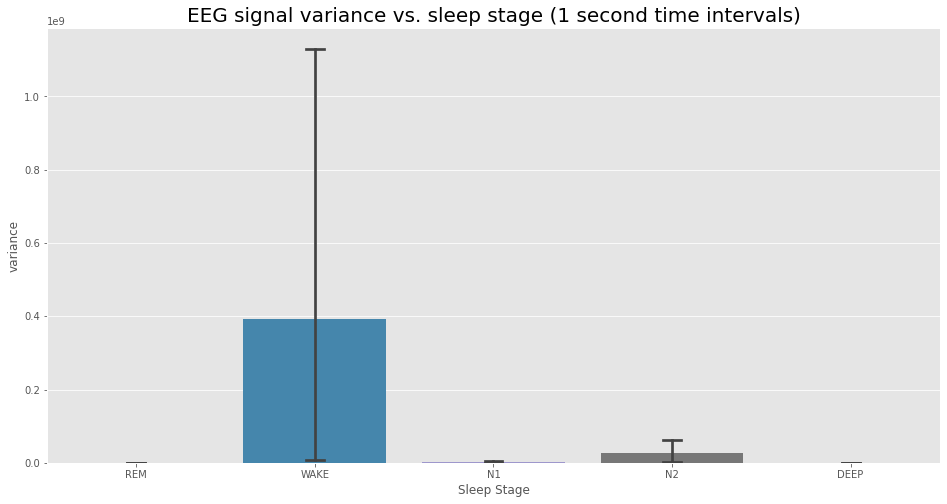

In [ ]:
#@title Visualize EEG signal vs. sleep stage
import seaborn as sns

def strided_window_reshape(x, window_size):
    # reshape 1D array according to strided window size (windows do not overlap)
    num_windows = x.shape[0] // window_size

    return x[:num_windows * window_size].reshape((-1, window_size))

# get variance for each 1-second interval in EEG signal
windows = strided_window_reshape(f['eeg1/filtered'][:], 250)

variances = np.var(windows, axis=1)

# get median for each 30-second interval in variance signal
variances_windowed = strided_window_reshape(variances, 30)

median_variances = np.median(variances_windowed, axis=1)

sleep_stages = np.unique(hypnogram_df['Sleep Stage'])

sleep_stage_variances = {}

df_dict = []

for sleep_stage in sleep_stages:
    median_variance = median_variances[np.where(hypnogram_df['Sleep Stage'] == sleep_stage)[0]]

    for v in median_variance:
        df_dict.append({'Sleep Stage': stages_to_real_names[sleep_stage],
                        'variance': v})


eeg_var_df = pd.DataFrame(df_dict).dropna()

with plt.style.context('ggplot'):
    plt.figure(figsize=(16, 8))

    plt.title('EEG signal variance vs. sleep stage (1 second time intervals)',
              fontsize=20)

    sns.barplot(x='Sleep Stage', y='variance', data=eeg_var_df,
                capsize=.1)

Indeed, we see that there is a large amount of variability in this variance across different sleep stages. In particular, we see that the WAKE stage is particularly chaotic. However, at least visually, we see very little difference between deep sleep and REM sleep in terms of the variance of the EEG signal.

# 5. Data analysis

DISCLAIMER: the analyses below may not be 100% biologically or scientifically grounded; the code is here to assist in your process, if you are interested in asking these kinds of questions.

## 5.1. Variance of EEG signal vs. stage

Here, we'll just use what we already computed earlier in section 4.3 (`eeg_var_df`, a DataFrame hidden behind the code fold) and compute a statistical test on that, for due diligence.

In [ ]:
from scipy.stats import ttest_ind

wake_var = eeg_var_df[eeg_var_df['Sleep Stage'] == 'WAKE']['variance']

sleep_var = eeg_var_df[eeg_var_df['Sleep Stage'] != 'WAKE']['variance']

res = ttest_ind(wake_var, sleep_var)

print(f'P-value: {res.pvalue:.3g}')

P-value: 2.42e-05


Looks significant!

## 5.2. Norm of acceleration vs. stage

For our next analysis, we'll do a similar analysis (with 1 second time intervals as well), but with the norm of the acceleration instead. First, we'll do the same plot, just to get an idea of what's going on.

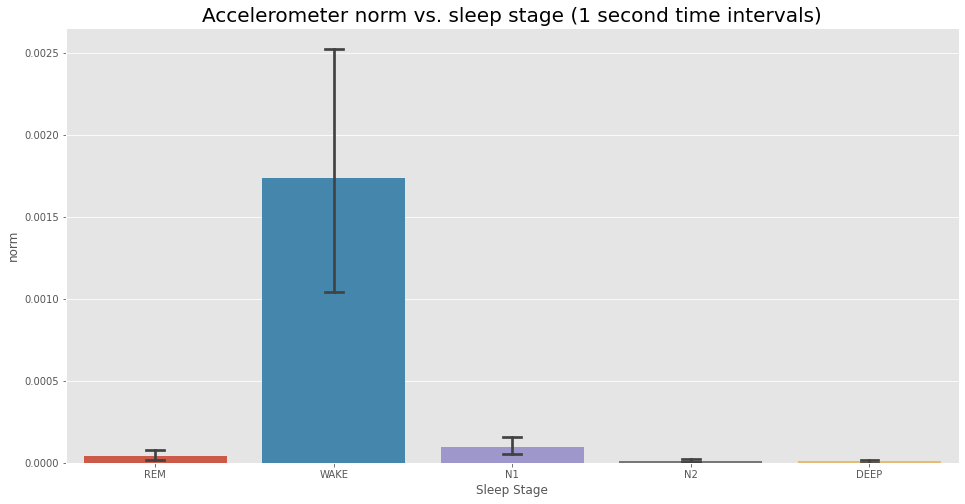

In [ ]:
#@title Plot accelerometer norm vs. sleep stage
acc_norm = np.sum([f[k]['filtered'][:] ** 2 for k in ['accelerometer_x', 'accelerometer_y', 'accelerometer_z']], axis=0)

# get variance for each 1-second interval in acc norm
windows = strided_window_reshape(acc_norm, 50)

variances = np.median(windows, axis=1)

# get median for each 30-second interval in variance signal
variances_windowed = strided_window_reshape(variances, 30)

median_variances = np.median(variances_windowed, axis=1)

sleep_stages = np.unique(hypnogram_df['Sleep Stage'])

sleep_stage_variances = {}

df_dict = []

for sleep_stage in sleep_stages:
    median_variance = median_variances[np.where(hypnogram_df['Sleep Stage'] == sleep_stage)[0]]

    for v in median_variance:
        df_dict.append({'Sleep Stage': stages_to_real_names[sleep_stage],
                        'norm': v})


acc_norm_df = pd.DataFrame(df_dict).dropna()

with plt.style.context('ggplot'):
    plt.figure(figsize=(16, 8))

    plt.title('Accelerometer norm vs. sleep stage (1 second time intervals)',
              fontsize=20)

    sns.barplot(x='Sleep Stage', y='norm', data=acc_norm_df,
                capsize=.1)

Now let's again compute a two-tailed T-test, again for due diligence.

In [ ]:
from scipy.stats import ttest_ind

wake_var = acc_norm_df[acc_norm_df['Sleep Stage'] == 'WAKE']['norm']

sleep_var = acc_norm_df[acc_norm_df['Sleep Stage'] != 'WAKE']['norm']

res = ttest_ind(wake_var, sleep_var)

print(f'P-value: {res.pvalue:.3g}')

P-value: 1.46e-69


Significant, as expected.